In [37]:
import os
import copy
import stanza
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
#stanza.download('en')

nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma,depparse')

2020-09-28 00:56:35 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-09-28 00:56:35 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-09-28 00:56:35 INFO: Use device: gpu
2020-09-28 00:56:35 INFO: Loading: tokenize
2020-09-28 00:56:35 INFO: Loading: pos
2020-09-28 00:56:36 INFO: Loading: lemma
2020-09-28 00:56:36 INFO: Loading: depparse
2020-09-28 00:56:37 INFO: Done loading processors!


In [49]:
relationPriority = {
    "nsubj": 1,
    "obj": 2,
    "obl": 2,
    "det": 3,
    "amod": 2,
    "case": 4,
    "root": 0
}

def dependencyParse(sentence):
    parsed = nlp(sentence)
    parse_tree = [postProcess(sent, word) for sent in parsed.sentences for word in sent.words]
    return parse_tree
    
def postProcess(sent, word):
    tree_node = [word.deprel, word.text, sent.words[word.head-1].text if word.head > 0 else "root"]
    printTree(tree_node)
    return tree_node

def printTree(tree):
    print(f'word: {tree[1]}\thead: {tree[2]}\tdeprel: {tree[0]}', sep='\n')

In [50]:
class BinaryParseTree:
    def __init__(self, val, left, right):
        self.val = val
        self.left = left
        self.right = right
        
    def isTree(self):
        return not (type(left) is str and type(right) is str)
    
    def getVal(self):
        return self.val
    
    def getLeft(self):
        return self.left
    
    def getRight(self):
        return self.right

In [51]:
sentences = ["Every good student study the math", "Every young student play the piano", "Some doctors work with no chemist"]

parseForest = []
for sent in sentences:
    print(sent)
    parseForest.append(dependencyParse(sent))

Every good student study the math
word: Every	head: student	deprel: det
word: good	head: student	deprel: amod
word: student	head: study	deprel: nsubj
word: study	head: root	deprel: root
word: the	head: math	deprel: det
word: math	head: study	deprel: obj
Every young student play the piano
word: Every	head: student	deprel: det
word: young	head: student	deprel: amod
word: student	head: play	deprel: nsubj
word: play	head: root	deprel: root
word: the	head: piano	deprel: det
word: piano	head: play	deprel: obj
Some doctors work with no chemist
word: Some	head: doctors	deprel: det
word: doctors	head: work	deprel: nsubj
word: work	head: root	deprel: root
word: with	head: chemist	deprel: case
word: no	head: chemist	deprel: det
word: chemist	head: work	deprel: obl


In [52]:
def compose(head, priority, parseTree):
    children = list(filter(lambda x: x[2] == head, parseTree))
    topDeps = list(filter(lambda x: relationPriority[x[0]] == priority, children))
    if len(topDeps) == 0:
        return BinaryParseTree(head, "N", "N")
    else: 
        topDep = topDeps[0]
    parseTree.remove(topDep)
    left = compose(topDep[1], priority+1, parseTree)
    right = compose(topDep[2], priority+1, parseTree)
    binaryTree = BinaryParseTree(topDep[0], left, right)
    return binaryTree

def binarization(parseTree):
    root = list(filter(lambda x: x[0] == "root", parseTree))[0][1]
    return compose(root, 1, parseTree) 

In [53]:
def treeToList(binaryDepdency):
    def toList(tree):
        treelist = []
        if tree.getVal() not in relationPriority:
            treelist.append('W')
            treelist.append(tree.getVal())
        else:
            treelist.append(tree.getVal())
        
        left = tree.getLeft()
        right = tree.getRight()

        if left is not 'N':
            treelist.append(toList(left))
       
        if right is not 'N':
            treelist.append(toList(right))

        return treelist
    return toList(binaryDepdency)

In [54]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('tree.ps')
    cf.destroy()
    os.system('magick convert tree.ps tree.png')
    display(Image(filename='tree.png'))
    os.system('rm tree.ps tree.png')

(nsubj  (amod  (W  good)  (det  (W  Every)  (W  student)))  (obj  (det  (W  the)  (W  math))  (W  study)))


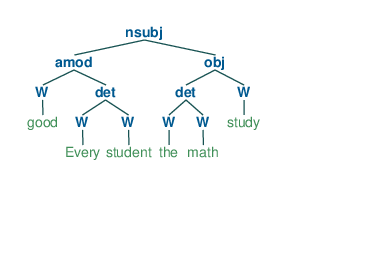

(nsubj  (amod  (W  young)  (det  (W  Every)  (W  student)))  (obj  (det  (W  the)  (W  piano))  (W  play)))


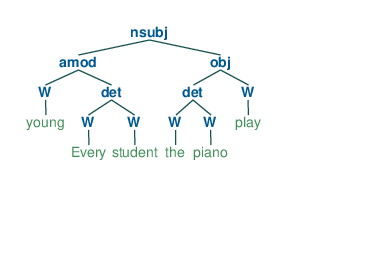

(nsubj  (W  doctors)  (obl  (det  (W  no)  (case  (W  with)  (W  chemist)))  (W  work)))


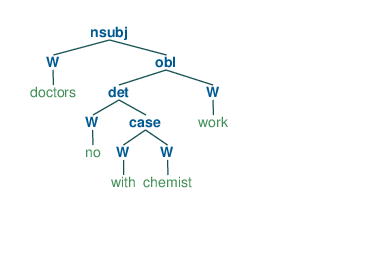

In [55]:
for tree in parseForest:
    parseTreeCopy = copy.deepcopy(tree)
    binaryDepdency = binarization(parseTreeCopy)
    sexpression = str(treeToList(binaryDepdency)).replace(',', ' ').replace("'", '').replace('[', '(').replace(']', ')')
    print(sexpression)
    treeViz = Tree.fromstring(sexpression)
    jupyter_draw_nltk_tree(treeViz)